<a href="https://colab.research.google.com/github/Shion1arch/Audivo/blob/main/HotelReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [7]:
# Read in data
df = pd.read_csv('hotel_reviews.csv', engine='python', encoding='latin1', on_bad_lines='skip', nrows=500)
print(df.shape)
# df = df.head(500) # This line is no longer needed as nrows=500 is used above
print(df.shape)

(500, 3)
(500, 3)


In [8]:
df.head()

,S.No.,Review,Rating
0,1,nice hotel expensive parking got good deal sta...,4
1,2,ok nothing special charge diamond member hilto...,2
2,3,nice rooms not 4* experience hotel monaco seat...,3
3,4,unique \tgreat stay \twonderful time hotel mon...,5
4,5,great stay great stay \twent seahawk game awes...,5


Quick EDA

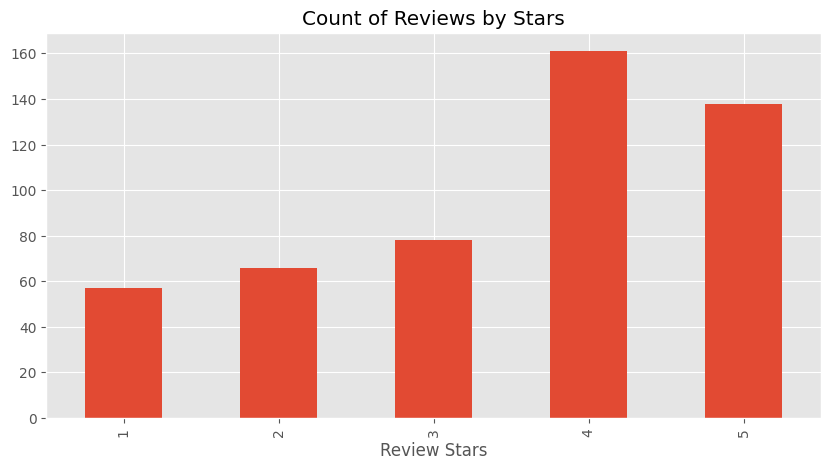

In [9]:
ax = df['Rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

Basic NLTK

In [10]:
example = df['Review'][50]
print(example)

excellent way stayed inn market memorial day weekend 	room large great view water sure request way advance 	hotel quiet fully booked crowded 	service impeccable staff well-mannered friendly 	ca n't fault anything.it great location right pike place market near lots great restaurants like etta chez shea 	 


In [11]:
nltk.download('punkt_tab')
tokens = nltk.word_tokenize(example)
tokens[:10]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


['excellent',
 'way',
 'stayed',
 'inn',
 'market',
 'memorial',
 'day',
 'weekend',
 'room',
 'large']

In [12]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['excellent',
 'way',
 'stayed',
 'inn',
 'market',
 'memorial',
 'day',
 'weekend',
 'room',
 'large']

In [13]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


[('excellent', 'JJ'),
 ('way', 'NN'),
 ('stayed', 'VBD'),
 ('inn', 'JJ'),
 ('market', 'NN'),
 ('memorial', 'JJ'),
 ('day', 'NN'),
 ('weekend', 'NN'),
 ('room', 'NN'),
 ('large', 'JJ')]

In [14]:
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


(S
  excellent/JJ
  way/NN
  stayed/VBD
  inn/JJ
  market/NN
  memorial/JJ
  day/NN
  weekend/NN
  room/NN
  large/JJ
  great/JJ
  view/NN
  water/NN
  sure/JJ
  request/NN
  way/NN
  advance/JJ
  hotel/NN
  quiet/JJ
  fully/RB
  booked/VBN
  crowded/VBN
  service/NN
  impeccable/JJ
  staff/NN
  well-mannered/JJ
  friendly/JJ
  ca/MD
  n't/RB
  fault/VB
  anything.it/RB
  great/JJ
  location/NN
  right/RB
  pike/JJ
  place/NN
  market/NN
  near/IN
  lots/NNS
  great/JJ
  restaurants/NNS
  like/IN
  etta/NN
  chez/NN
  shea/NN)


Step 1. VADER Seniment Scoring

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

import nltk
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [16]:
sia.polarity_scores('This is amazing!')

{'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'compound': 0.6239}

In [17]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [18]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'compound': 0.9782}

In [19]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    myid = row['S.No.']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'S.No.'})
vaders = vaders.merge(df, how='left')

In [21]:
# Now we have sentiment score and metadata
vaders.head()

,S.No.,neg,neu,pos,compound,Review,Rating
0,1,0.072,0.643,0.285,0.9747,nice hotel expensive parking got good deal sta...,4
1,2,0.110,0.701,0.189,0.9787,ok nothing special charge diamond member hilto...,2
2,3,0.081,0.700,0.219,0.9889,nice rooms not 4* experience hotel monaco seat...,3
3,4,0.060,0.555,0.385,0.9912,unique \tgreat stay \twonderful time hotel mon...,5
4,5,0.135,0.643,0.221,0.9797,great stay great stay \twent seahawk game awes...,5


Step 2: Plot VADER results

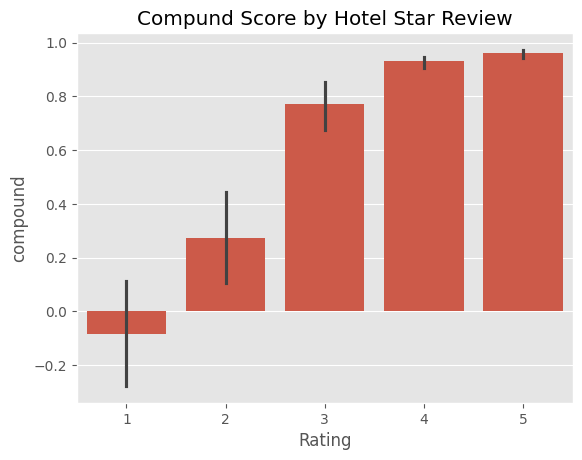

In [22]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compund Score by Hotel Star Review')
plt.show()

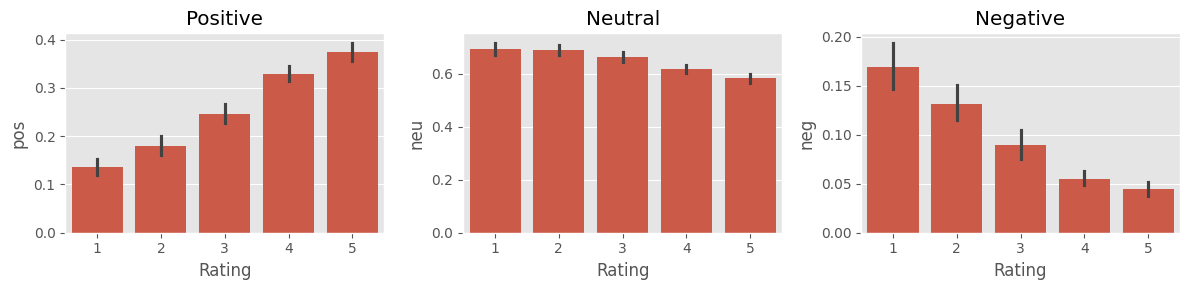

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=vaders, x='Rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Step 3. Roberta Pretrained Model

In [24]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [25]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [26]:
# VADER results on example
print(example)
sia.polarity_scores(example)

excellent way stayed inn market memorial day weekend 	room large great view water sure request way advance 	hotel quiet fully booked crowded 	service impeccable staff well-mannered friendly 	ca n't fault anything.it great location right pike place market near lots great restaurants like etta chez shea 	 


{'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'compound': 0.9782}

In [27]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.0033772597), 'roberta_neu': np.float32(0.043858767), 'roberta_pos': np.float32(0.9527639)}


In [28]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [29]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review']
        myid = row['S.No.']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 345
Broke for id 369
Broke for id 443
Broke for id 444
Broke for id 488


In [30]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'S.No.'})
vaders = vaders.merge(df, how='left')

SVM Model

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
# 1. Split dataset
X = df['Review']
y = df['S.No.']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [33]:
# 2. TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
df.head()

,S.No.,Review,Rating
0,1,nice hotel expensive parking got good deal sta...,4
1,2,ok nothing special charge diamond member hilto...,2
2,3,nice rooms not 4* experience hotel monaco seat...,3
3,4,unique \tgreat stay \twonderful time hotel mon...,5
4,5,great stay great stay \twent seahawk game awes...,5


In [34]:
# 3. Train SVM Model (Linear Kernel works best for text)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

SVC(kernel='linear')

In [35]:
# 4. Predictions
y_pred_svm = svm_model.predict(X_test_tfidf)

In [36]:
# 5. Evaluation
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

SVM Accuracy: 0.0

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       1.0
          10       0.00      0.00      0.00       1.0
          12       0.00      0.00      0.00       1.0
          15       0.00      0.00      0.00       0.0
          16       0.00      0.00      0.00       1.0
          18       0.00      0.00      0.00       0.0
          19       0.00      0.00      0.00       1.0
          22       0.00      0.00      0.00       0.0
          23       0.00      0.00      0.00       1.0
          29       0.00      0.00      0.00       0.0
          30       0.00      0.00      0.00       0.0
          31       0.00      0.00      0.00       1.0
          34       0.00      0.00      0.00       1.0
          35       0.00      0.00      0.00       0.0
          36       0.00      0.00     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import joblib

In [38]:
# 1. Prepare data (if not already split earlier in the notebook)
X = df['Review']
y = df['Rating']
# If you already have X_train/X_test defined above, you can skip this split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [39]:
# 2. Build a pipeline with TF-IDF and Logistic Regression
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

In [40]:
# 3. Train
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))])

In [41]:
# 4. Predict & Evaluate
y_pred_logreg = logreg_pipeline.predict(X_test)

In [42]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.37

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        11
           2       0.50      0.08      0.13        13
           3       0.00      0.00      0.00        16
           4       0.33      0.72      0.45        32
           5       0.48      0.46      0.47        28

    accuracy                           0.37       100
   macro avg       0.26      0.25      0.21       100
weighted avg       0.30      0.37      0.29       100


Confusion Matrix:
 [[ 0  1  1  9  0]
 [ 0  1  0 10  2]
 [ 0  0  0 13  3]
 [ 0  0  0 23  9]
 [ 0  0  0 15 13]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Compare Scores between models

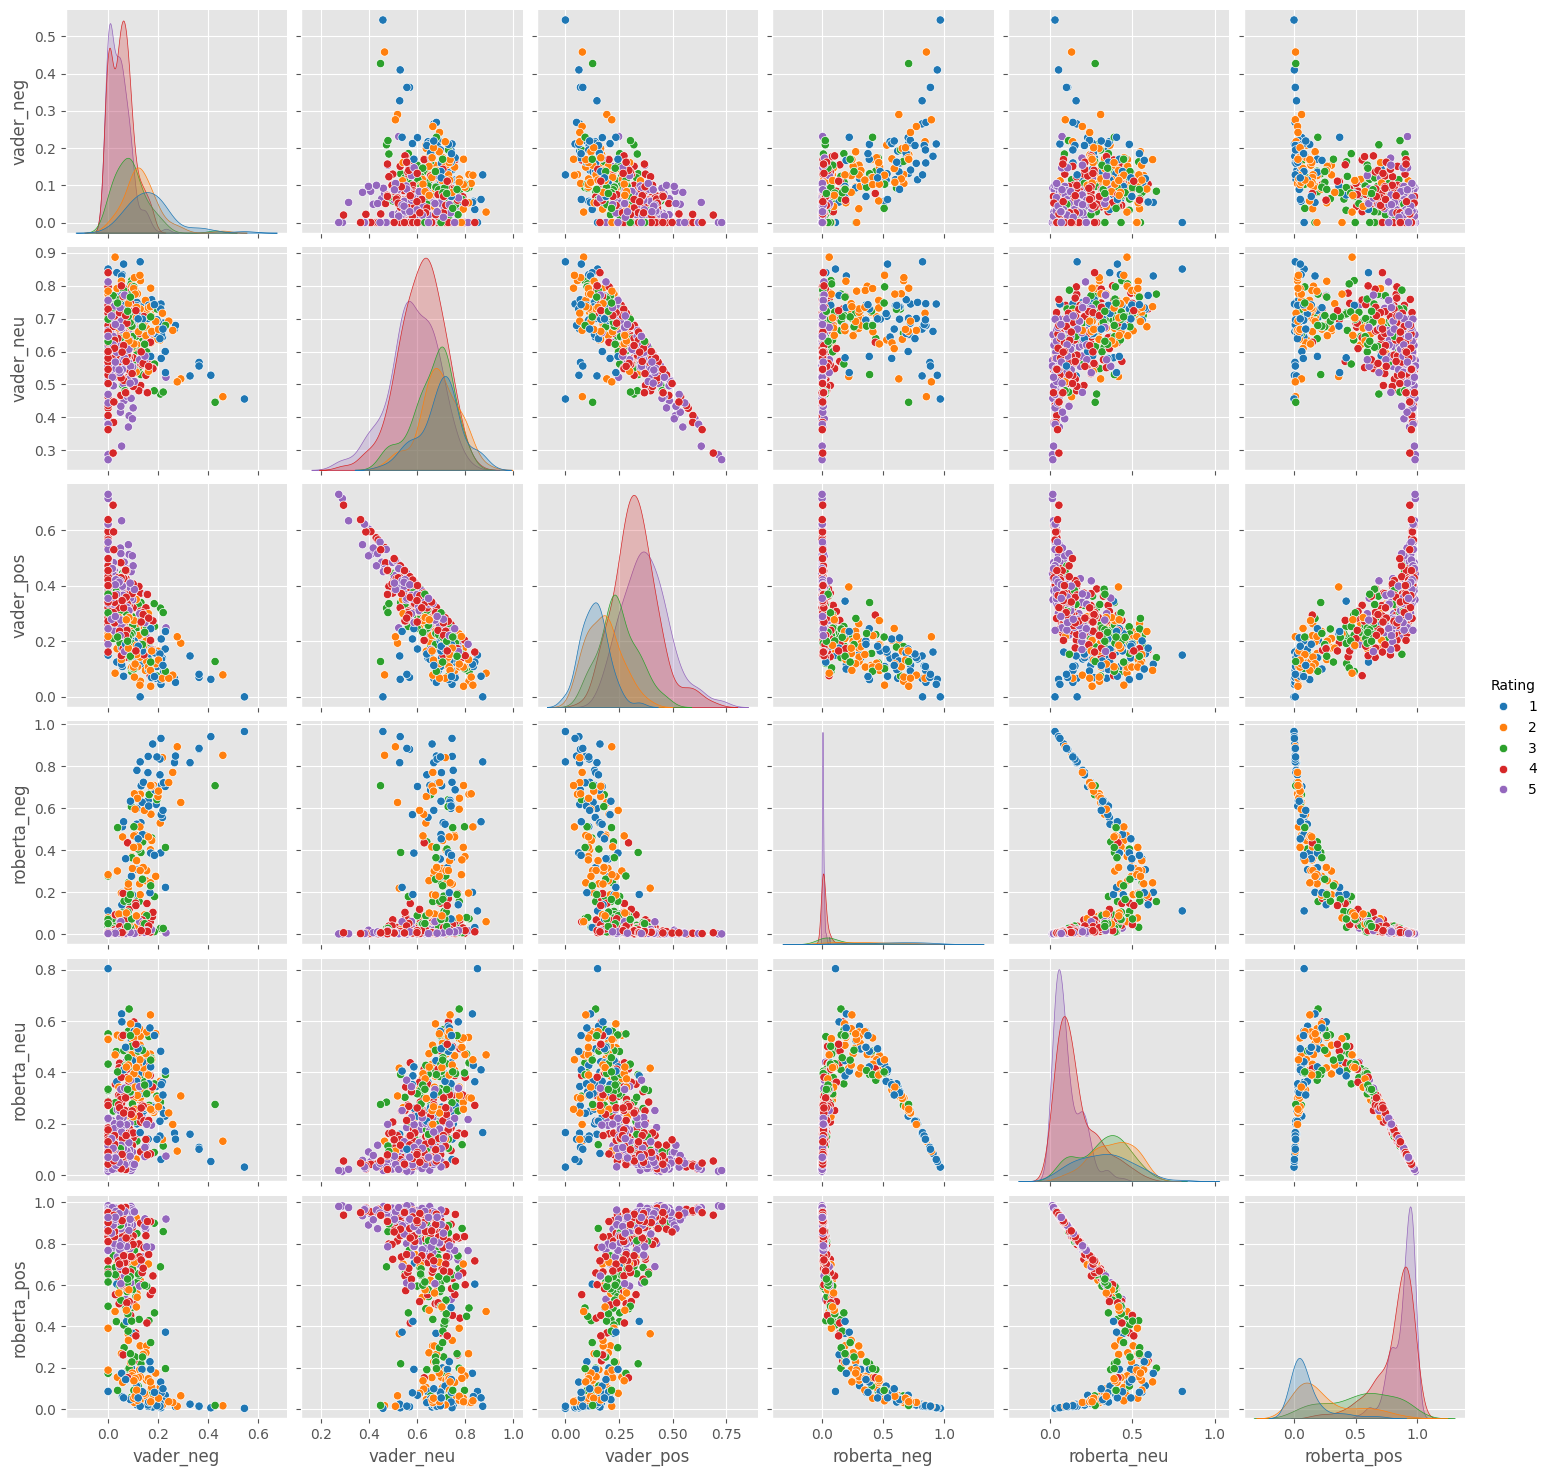

In [45]:
sns.pairplot(data=vaders,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Rating',
            palette='tab10')
plt.show()

Step 4: Review Examples:

In [46]:
vaders.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['Review'].values[0]

'stay away dirty rooms stayed far better places seattle \troom size prison cell window facing outside wall \tquiet showered flushed toilet \tplus seattle best coffee lobby right downtown \thotel limo expect pay 30 yellow cab \thotel staff helpful friendly \t '

In [47]:
vaders.query('Rating == 1') \
    .sort_values('vader_pos', ascending=False)['Review'].values[0]

"stay plenty nice hotels seattle \tnot \tterrible stay bellman lost luggage phones did n't work dirty sheets letter manager answered acknowledged \tbetter staying \t "

In [48]:
vaders.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['Review'].values[0]

'uber style super service maxmum comfort did not want leave \tadmit bit confused negative reviews w seattle \tnothing positive experiences.the w seattle caters hipster 26-35 crowd \tthink running shoe designers web moguls fasion mavens \tpeople wearing sunglasses elevators sort thing \tguess comes territory w certainly trendy.the w swathed somber seriously cool style swank lounge luxurious rooms \tbeds plush comfortable \troom felt like modern apartment instead hotel \taccents abounded stereo superior waffle robes zen desk waterfall \tbathroom stocked luscious bliss soaps.the staff friendly efficient \table check hours early no issue \treplaced lost room bar key pleasantly charging loss hotels might.i skipped bar \tbit taste \tenjoy company young beautiful people latest fashions love bar thriving.one minor drawback w tucked canyons corporate high rises little immediate area \t10-20 walk tourist areas like pioneer square pike place market \thowever.nonetheless stay \tamazing comfort \t 

In [49]:
vaders.query('Rating == 5') \
    .sort_values('vader_neg', ascending=False)['Review'].values[0]

"great seattle location great downtown hotel \tparking problem \tread reviews hotel parking 35 overnite \tparked block away convention center 18.short 6 block walk pike place market \tn't miss excellent dinner hotel daily grill definitely stay \t "

In [50]:
svm_models = {}
svm_models['SVM'] = accuracy_score(y_test, y_pred_svm)

Extra: The Transformers Pipeline

In [51]:
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svm', SVC(kernel='linear'))
])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))


SVM Accuracy: 0.47


In [52]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


In [53]:
joblib.dump(logreg_pipeline, "logreg_pipeline.joblib")
print("\\nSaved trained pipeline to logreg_pipeline.joblib")

\nSaved trained pipeline to logreg_pipeline.joblib


In [54]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [56]:
sent_pipeline('Why was it so boring')

[{'label': 'NEGATIVE', 'score': 0.9996654987335205}]